# IPBMA_6: Projection Radiography
### Author: Liu Cong and Ulloa Ferrer,Leonardo

In [117]:
import numpy as np
import matplotlib.pyplot as pyplot
import sys, os

try:
    auxFnc = os.path.join(sys.path[0], 'auxFiles', 'auxFnc.py')
    phantomsFnc = os.path.join(sys.path[0], 'auxFiles', 'phantomsFnc.py')
    plotFnc = os.path.join(sys.path[0], 'auxFiles', 'plotFnc.py')
    %run {auxFnc}
    %run {phantomsFnc}
    %run {plotFnc}
except:
    auxFnc = os.path.join('.', 'auxFiles', 'auxFnc.py')
    phantomsFnc = os.path.join('.', 'auxFiles', 'phantomsFnc.py')
    plotFnc = os.path.join('.', 'auxFiles', 'plotFnc.py')
    %run {auxFnc}
    %run {phantomsFnc}
    %run {plotFnc}

SOURCE

In [84]:
# source(kVp, N0)
# return number of photoms (N0), efective energy (eE)

kVp= 30
I0= 250  
N0, eE= source(kVp, I0)

print(N0, eE)

250 12.0


BREAST PHANTOM

In [118]:
# OBJECT
# phantom(size, eE)
# return phantomData

size= 256
obj= breast_phantom(size, eE)

0.0 2.27 3.19 4.14


0.0 2.27 3.19 4.14


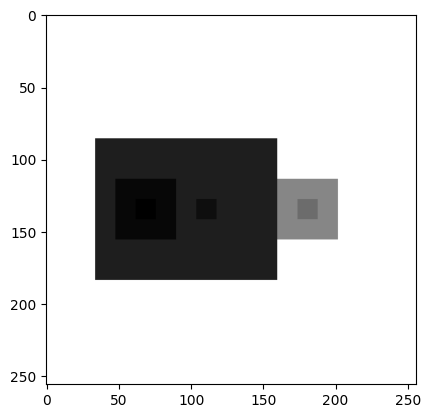

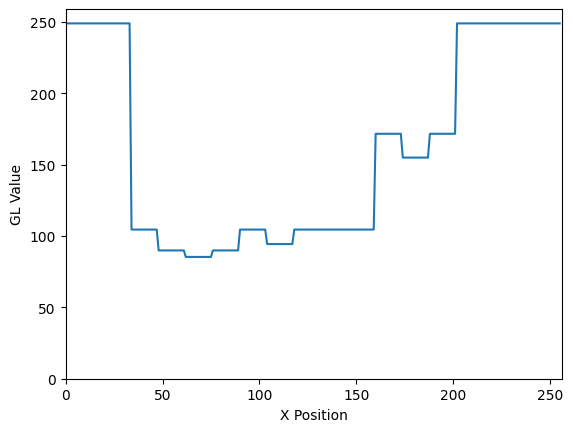

In [169]:
# test
from auxFiles.auxFnc import get_coef

def breast_phantom(edge_size, energy):
    breast_coef = get_coef(3,energy)
    air_coef = get_coef(1,energy)
    soft_coef = get_coef(4,energy)
    adipose_coef = get_coef(0,energy)

    print(round(air_coef, 2), round(adipose_coef, 2), round(breast_coef, 2), round(soft_coef, 2))


    cell_size = edge_size//18
    frame = np.full((edge_size, edge_size, edge_size), air_coef)
    mid_point = edge_size//2

    # putting breast adipose 
    frame[1 + mid_point - 4*cell_size: mid_point + 3*cell_size + 1,
          mid_point - 3*cell_size: mid_point + 4*cell_size,
          mid_point - 10 - 6*cell_size: mid_point + 3*cell_size - 10] = adipose_coef
      
    # putting breast tissue 
    frame[1 + mid_point - 2*cell_size: mid_point + cell_size + 1,
          mid_point - cell_size: mid_point + 2*cell_size,
          mid_point - 10 - 5*cell_size: mid_point - 2*cell_size - 10] = breast_coef
    
    # putting soft tissue
    frame[1 + mid_point - cell_size: mid_point + 1,
          mid_point: mid_point + cell_size,
          mid_point - 10 - 4*cell_size: mid_point - 3*cell_size - 10] = soft_coef

    # putting right most square
    frame[1 + mid_point - 2*cell_size: mid_point + cell_size + 1,
          mid_point - cell_size: mid_point + 2*cell_size,
          mid_point - 10 + 3*cell_size: mid_point + 6*cell_size - 10] = adipose_coef
      
    # putting second soft tissue
    frame[1 + mid_point - cell_size: mid_point + 1,
          mid_point: mid_point + cell_size,
          mid_point - 10 - cell_size: mid_point - 10] = soft_coef

    # putting third soft tissue
    frame[1 + mid_point - cell_size: mid_point + 1,
          mid_point: mid_point + cell_size,
          mid_point - 10 + 4*cell_size: mid_point + 5*cell_size - 10] = soft_coef
    
    return frame

size= 256
obj= breast_phantom(size, eE)
prj= 'lateral'
qImage= interactor_PR(N0, obj, prj)
pyplot.imshow(qImage, cmap="gray")
pyplot.show()
plotLineH(qImage, 128)

QUANTUM IMAGE. FRONTAL VIEW.

In [119]:
# Interaction
# return qImage -> Quantum Image, ideal conditions

prj= 'frontal'
qImage= interactor_PR(N0, obj, prj)

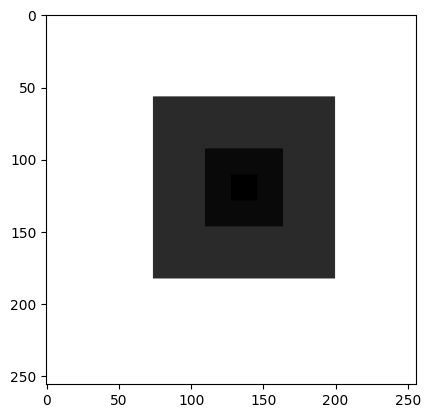

In [120]:
pyplot.imshow(qImage, cmap="gray")
pyplot.show()

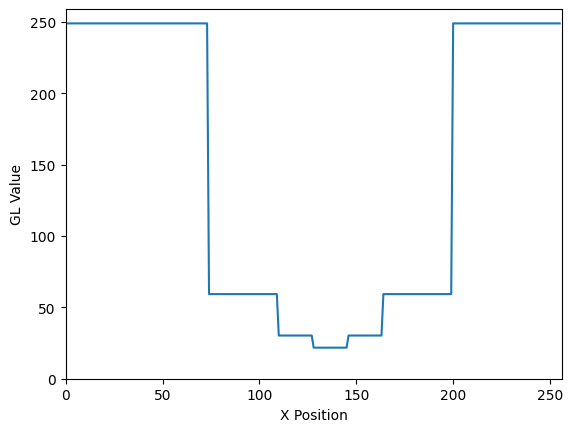

In [121]:
plotLineH(qImage, 128)

In [89]:
# Get Distribution of cells per Photons

nCP= getNumberCellsPhoton(qImage, N0)
print(f'Number of Cells (Quantum image): {int(sum(nCP[1])):d}')

Number of Cells (Quantum image): 65536


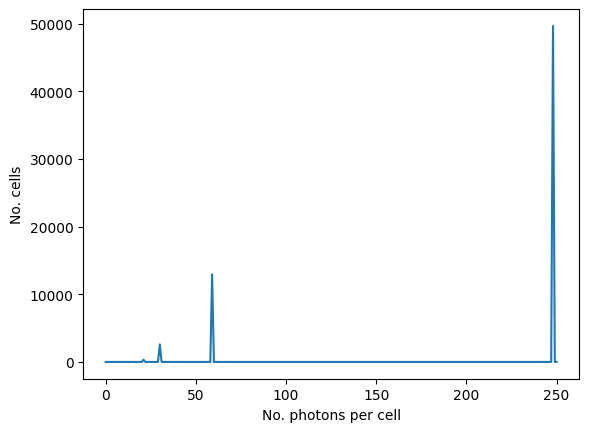

In [90]:
plotDistribution(nCP, 'No. photons per cell', 'No. cells')

QUANTUM IMAGE. LATERAL VIEW.

In [91]:
# Interaction
# return qImage -> Quantum Image, ideal conditions

prj= 'lateral'
qImage= interactor_PR(N0, obj, prj)

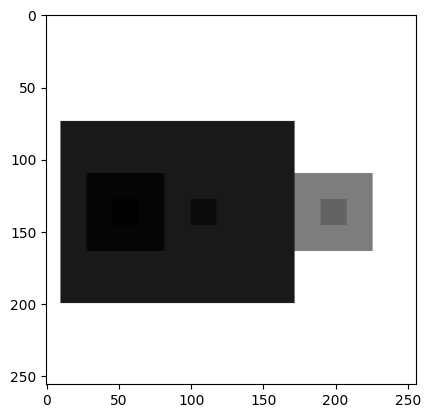

In [92]:
pyplot.imshow(qImage, cmap="gray")
pyplot.show()

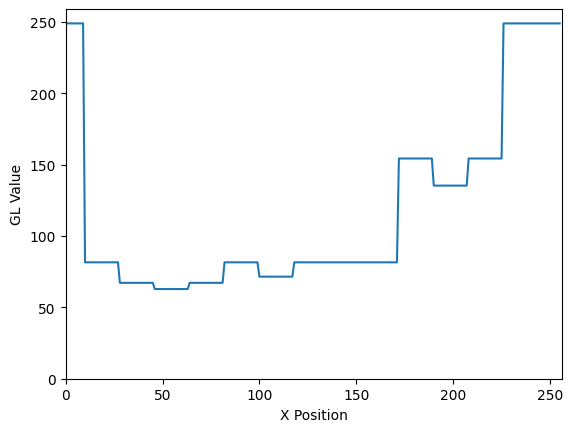

In [93]:
plotLineH(qImage, 128)

In [94]:
# fName= "coefAtenuacionAir.csv"
fName= "coefAtenuacionCalcium.csv"
mu= getCoef(fName, eE)
sArtifact= 2
print(mu)

90504.95999999999


In [95]:
def insertArtifact(obj, pos, sizeArtifact, mu):
    radius = int(sizeArtifact / 2)

    x0, y0, z0 = pos

    x_range = np.arange(-radius, radius + 1)
    y_range = np.arange(-radius, radius + 1)
    z_range = np.arange(-radius, radius + 1)

    X, Y, Z = np.meshgrid(x_range, y_range, z_range, indexing='ij')

    spherical_mask = (X**2 + Y**2 + Z**2) <= radius**2
    
    for i in range(-radius, radius + 1):
        for j in range(-radius, radius + 1):
            for k in range(-radius, radius + 1):
                x, y, z = x0 + i, y0 + j, z0 + k
                if (0 <= x < obj.shape[0] and 0 <= y < obj.shape[1] and 0 <= z < obj.shape[2]):
                    if spherical_mask[i + radius, j + radius, k + radius]:
                        obj[x, y, z] = mu
    return obj

pos_1= [72, 120, 120]
obj_microCal= insertArtifact(obj, pos_1, sArtifact, mu)

pos_2= [144, 120, 120]
obj_microCal= insertArtifact(obj_microCal, pos_2, sArtifact, mu)

pos_3= [214, 120, 120]
obj_microCal= insertArtifact(obj_microCal, pos_3, sArtifact, mu)

In [96]:
qImage= interactor_PR(N0, obj_microCal, prj)

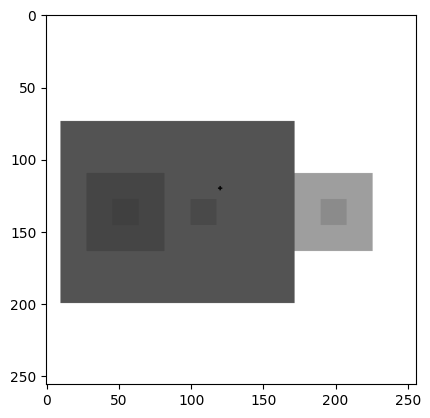

In [97]:
pyplot.imshow(qImage, cmap="gray")
pyplot.show()